
Eigenenergies (eV) [sorted]:
  State 1: -9.702664 eV
  State 2: -8.814794 eV
  State 3: -7.350499 eV
  State 4: -5.341067 eV
  State 5: -2.861270 eV
  State 6: -0.194173 eV
  State 7: 1.232076 eV
  State 8: 1.771539 eV
  State 9: 3.444511 eV
  State 10: 5.285532 eV
(... higher states may be unbound if E >= 0 ...)



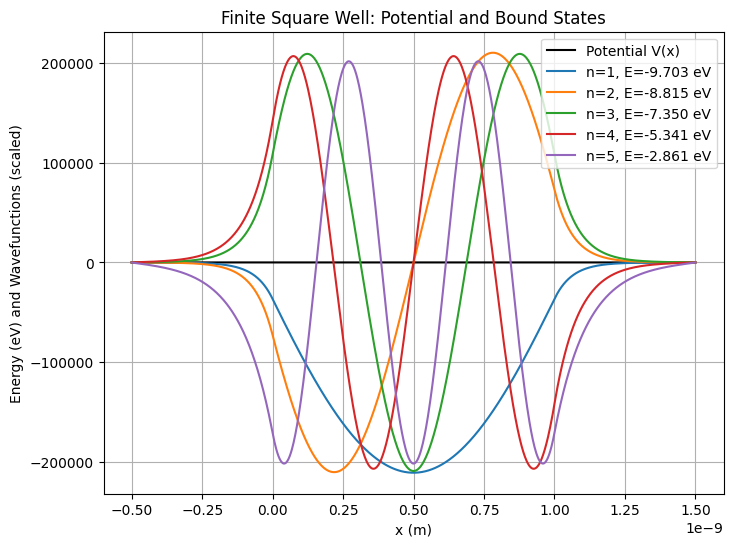

In [1]:
#!/usr/bin/env python3

import numpy as np
import matplotlib.pyplot as plt

def solve_finite_square_well(mass, L, well_depth_eV, N=1000):
    """
    Solve the 1D finite square well problem using a finite-difference
    approximation of the time-independent Schrödinger equation:
        [-(hbar^2)/(2m) * d^2/dx^2 + V(x)] psi(x) = E * psi(x)

    Parameters
    ----------
    mass : float
        Mass of the particle (in kg).
    L : float
        Width of the well (in m).
    well_depth_eV : float
        Depth of the well in eV. Inside the well, V(x) = -V0 (in eV),
        outside the well, V(x) = 0 (in eV).
    N : int, optional
        Number of grid points in the total domain (default=1000).

    Returns
    -------
    energies_eV : ndarray
        Eigenvalues (energies) in eV, sorted in ascending order.
    wavefuncs : ndarray
        2D array of eigenfunctions evaluated on the grid.
    x : ndarray
        Coordinate array of length N (from x_min to x_max).
    Vx_eV : ndarray
        Potential array (in eV) on the same grid.
    """
    # Physical constants
    hbar = 1.054571817e-34      # J*s (reduced Planck's constant)
    eV_to_J = 1.602176634e-19   # 1 eV in Joules

    # Convert well depth from eV to Joules
    well_depth_J = well_depth_eV * eV_to_J

    # Choose a domain that extends beyond [0, L] so that the wavefunction
    # decays to ~0 at the boundaries. For example, extend 0.5L on each side.
    x_min = -0.5 * L
    x_max =  1.5 * L

    # Create spatial grid
    x = np.linspace(x_min, x_max, N)
    dx = x[1] - x[0]

    # Construct the potential V(x) (in Joules)
    Vx = np.zeros_like(x)
    for i in range(N):
        if 0 <= x[i] <= L:
            Vx[i] = -well_depth_J
        else:
            Vx[i] = 0.0

    # Kinetic energy operator coefficient
    coeff_kin = - (hbar**2) / (2.0 * mass * dx**2)

    # Build the Hamiltonian matrix using a finite-difference approximation
    main_diag = np.zeros(N)
    off_diag = np.ones(N-1)
    for i in range(N):
        main_diag[i] = -2.0 * coeff_kin + Vx[i]
    H = (np.diag(main_diag) +
         np.diag(off_diag * coeff_kin, k=1) +
         np.diag(off_diag * coeff_kin, k=-1))

    # Diagonalize the Hamiltonian
    eigenvals, eigenvecs = np.linalg.eigh(H)
    
    # Sort eigenvalues and corresponding eigenvectors
    idx = np.argsort(eigenvals)
    eigenvals = eigenvals[idx]
    eigenvecs = eigenvecs[:, idx]

    # Convert eigenvalues from Joules to eV
    energies_eV = eigenvals / eV_to_J

    # Normalize eigenfunctions so that ∫|ψ|^2 dx ≈ 1
    for i in range(eigenvecs.shape[1]):
        norm = np.sqrt(np.sum(np.abs(eigenvecs[:, i])**2) * dx)
        eigenvecs[:, i] /= norm

    # Convert the potential to eV for plotting
    Vx_eV = Vx / eV_to_J

    return energies_eV, eigenvecs, x, Vx_eV

def main():
    """
    Main function:
      1) Prompts the user for mass (kg), well width (m), and well depth (eV).
      2) Solves the finite square well problem.
      3) Prints eigenenergies (in eV).
      4) Plots the potential and a few bound-state wavefunctions (E < 0).
    """
    try:
        mass = float(input("Enter the mass (in kg): "))
        L = float(input("Enter the width of the well (in m): "))
        well_depth_eV = float(input("Enter the depth of the well (in eV): "))
    except ValueError:
        print("Invalid input. Please enter numerical values.")
        return

    # Number of grid points
    N = 1000

    # Solve the finite square well problem
    energies_eV, wavefuncs, x, Vx_eV = solve_finite_square_well(mass, L, well_depth_eV, N)

    # Print the first several eigenenergies
    print("\nEigenenergies (eV) [sorted]:")
    for i, E in enumerate(energies_eV[:10], start=1):
        print(f"  State {i}: {E:.6f} eV")
    print("(... higher states may be unbound if E >= 0 ...)\n")

    # Identify bound states (E < 0) and plot them
    bound_indices = np.where(energies_eV < 0)[0]
    n_to_plot = min(len(bound_indices), 5)  # plot up to 5 bound states

    plt.figure(figsize=(8,6))
    plt.plot(x, Vx_eV, 'k-', label="Potential V(x)")

    for i in range(n_to_plot):
        idx_state = bound_indices[i]
        E = energies_eV[idx_state]
        psi = wavefuncs[:, idx_state]
        # Scale and shift wavefunction for visualization
        scale = 0.5 * abs(np.min(Vx_eV))
        y_psi = psi * scale + E
        plt.plot(x, y_psi, label=f"n={i+1}, E={E:.3f} eV")

    plt.title("Finite Square Well: Potential and Bound States")
    plt.xlabel("x (m)")
    plt.ylabel("Energy (eV) and Wavefunctions (scaled)")
    plt.legend()
    plt.grid(True)
    plt.show()

if __name__ == "__main__":
    main()
